#进入工作目录

In [8]:
from pathlib import Path
print(Path.cwd())

# %cd /content/drive/Colab Notebooks/baby_sound

C:\Users\Muelsyse\OneDrive\F_Drive\y2z\Md\优才\work


#自定义测试集文件

#util 获得音频文件的时长,函数    并裁剪音频至10s以内，删除原音频

In [9]:
import contextlib
import wave
from pydub import AudioSegment
import os

splited_flag = False
def handle_wav_to_len(file_path,file_name,to_file_path):
    global splited_flag
    with contextlib.closing(wave.open(file_path, 'r')) as f:
        song = AudioSegment.from_wav(file_path)
        wav_length = song.duration_seconds
        print("音频长度：",wav_length,"秒")
        file_name_title=file_name.split('.wav')[0]
        if os.path.isdir(to_file_path) == False:
            os.makedirs(to_file_path)
        if wav_length>20:
            every_length = wav_length/3
            print(every_length)
            first_sound = song[:every_length*1000]
            second_sound = song[every_length*1000:every_length*2*1000]
            third_sound = song[every_length*2000:]
            print(third_sound.duration_seconds)
            first_sound.export(to_file_path+file_name_title+"_1.wav", format="wav")
            second_sound.export(to_file_path+file_name_title+"_2.wav", format="wav")
            third_sound.export(to_file_path+file_name_title+"_3.wav", format="wav")
            splited_flag = True
        elif wav_length<=20 and wav_length>10:
            every_length = int(wav_length/2)
            first_sound = song[:every_length*1000]
            second_sound = song[every_length*1000:]
            first_sound.export(to_file_path+file_name_title+"_1.wav", format="wav")
            second_sound.export(to_file_path+file_name_title+"_2.wav", format="wav")
            splited_flag = True
        else:
            song.export(to_file_path+file_name_title+"_1.wav", format="wav")

# base_file_path = './train/'
# file_name = "awake_0.wav"
# handle_wav_to_len(base_file_path,file_name)

### 处理数据 分割数据长度

由于原数据集中数据长度从 6s到30s不等，而我们希望所有音频长度严格不超过10s，因此需要对数据集加以处理并将处理后内容输出到训练数据文件夹。大于 20s平均 分成 3 份、大于10s 小于20s 平均分成两份、小于 10s 则直接复制。
从 work/train 裁剪到 train 中。

In [10]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

#获取文件分类列表 ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
# class_name_arr = tf.io.gfile.listdir('./work/train')
# for single_filename in class_name_arr:
#   #获取文件目录下的文件列表
#   # print('./train/'+single_filename)
#   doc_name_arr = tf.io.gfile.listdir('./work/train/'+single_filename)
#   for doc_name_item in doc_name_arr:
#     # print(temp_filepath)
#     file_path = './work/train/'+single_filename+'/'+doc_name_item
#     to_file_path = './train/'+single_filename+'/'
#     handle_wav_to_len(file_path,doc_name_item,to_file_path)
#     print(file_path)

# 如果数据都正确切分就不处理
# print(splited_flag)

### 预处理

尝试用 librosa 读取并可视化音频数据。选取其中一个样本音频，以原采样率输出其**波形图**。

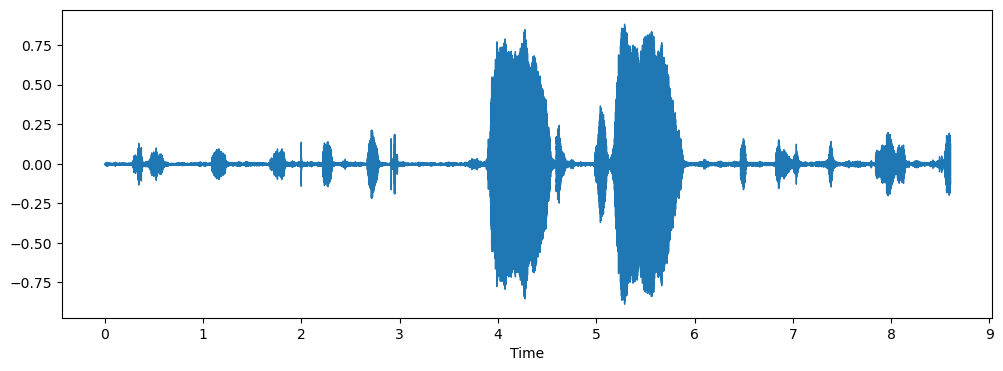

In [11]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import os

# Class: awake
filename = './train/awake/awake_48_1.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

#公共函数

### 变量保存至本地

运用了 pickle 库保存和读取变量到文件。避免重复冗余的数据集构建计算。

In [3]:
import pickle
def save_variable(v,filename):
  f=open(filename,'wb')
  pickle.dump(v,f)
  f.close()
  return filename
 
def load_variavle(filename):
  f=open(filename,'rb')
  r=pickle.load(f)
  f.close()
  return r
# filename = save_variable(audiodf,'audiodf.txt')
# audiodf = load_variavle('audiodf.txt')

### 获取 .wav 文件属性数据

主要获取采样率、声道数与位深度信息。

In [ ]:
import struct

class WavFileHelper():
    def read_file_properties(self, filename):
        wave_file = open(filename,"rb")
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)


接下来，我们将遍历每个音频样本文件并提取音频声道数、采样率和位深度。

位深度是指图像中存储的色彩信息。图像的位深度越高，可存储的颜色就越多。最简单的图像，即 1 位图像，只能显示黑白两种颜色。这是因为 1 位只能存储 0（白色）和 1（黑色）两个值中的一个。8 位图像可以存储 256 种可能的颜色，而 24 位图像可以显示超过 1600 万种颜色。随着比特深度的增加，图像的文件大小也会增加，因为图像中的每个像素都需要存储更多的颜色信息。

CD 级音频的标准采样率为 44.1 千赫兹（44100 赫兹）。一般录制的普通音频的采样率往往更低。

音频文件可以包含一个、两个甚至更多声道。特别是在环绕声的情况下，需要更多的音频通道来营造声音的立体感。

尝试利用定义的 .wav 属性获取函数输出样本音频的声道数、采样率、位深度。

In [ ]:
# num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

In [ ]:
# sample rates 

print(audiodf.sample_rate.value_counts(normalize=True))

In [ ]:
# bit depth

print(audiodf.bit_depth.value_counts(normalize=True))

### 获取并存储所有数据集内音频文件属性

In [13]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

def get_adata(basepath):
    wavfilehelper = WavFileHelper()
    audiodata = []
    #获取文件分类列表 
    class_name_arr = tf.io.gfile.listdir(basepath)
    #  ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
    for single_filename in class_name_arr:
      print(single_filename+" handling...")
      #获取文件目录下的文件列表
      # print('。、train/'+single_filename)
      doc_name_arr = tf.io.gfile.listdir(basepath+single_filename)
      for doc_name_item in doc_name_arr:
        temp_filepath = basepath+single_filename+'/'+doc_name_item
        # print(temp_filepath)
        data = wavfilehelper.read_file_properties(temp_filepath)
        audiodata.append(data)
    return pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])
# Convert into a Panda dataframe
# audiodf = get_adata('./train/')
# audiodf2 = get_adata('./temp/')
#数据存储
# save_variable(audiodf,'audiodf_cnn.txt')
# save_variable(audiodf2,'audiodf_cnn.txt')

In [14]:
audiodf = load_variavle('audiodf_cnn.txt')

接下来测试对于音频数据属性的调整。

In [15]:
from scipy.io import wavfile as wav
import numpy as np

# filename = './UrbanSound8K/audio/fold1/24074-1-0-7.wav' 
filename = './train/awake/awake_48_2.wav'

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 16000
Librosa sample rate: 22050


这里是 librosa 将音频转换为 22.05 KHz 的示例。

In [16]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -32768 to 29531
Librosa audio file min~max range: -1.0120575 to 0.88845086


在声音处理领域中，梅尔频率倒谱(Mel-Frequency Cepstrum)是基于声音频率的非线性梅尔刻度(mel scale)的对数能量频谱的线性变换。

梅尔频率倒谱系数 (Mel-Frequency Cepstral Coefficients，MFCCs)就是组成梅尔频率倒谱的系数。它衍生自音讯片段的倒频谱(cepstrum)。倒谱和梅尔频率倒谱的区别在于，梅尔频率倒谱的频带划分是在梅尔刻度上等距划分的，它比用于正常的对数倒频谱中的线性间隔的频带更能近似人类的听觉系统。 这样的非线性表示，可以在多个领域中使声音信号有更好的表示。例如在音讯压缩中。

梅尔频率倒谱系数（MFCC）广泛被应用于语音识别的功能。他们由Davis和Mermelstein在1980年代提出，并在其后持续是最先进的技术之一。在MFCC之前，线性预测系数（LPCS）和线性预测倒谱系数（LPCCs）是自动语音识别的的主流方法。

Librosa 的 mfcc() 函数从时间序列音频数据生成 MFCC。MFCCs是一个在语音识别和说话者识别领域被广泛运用的特征。

一开始只提取 MFCC 特征用于语音识别，提取维度为 $40$，提取出的特征可视化后如图所示。

(40, 371)
[[-2.63911102e+02 -2.56016968e+02 -2.58369751e+02 ... -3.54226746e+02
  -3.86597839e+02 -4.23095673e+02]
 [ 1.70809479e+02  1.48501068e+02  1.22617325e+02 ...  1.03909607e+02
   9.13994446e+01  8.12289429e+01]
 [-4.34209404e+01 -4.86925888e+01 -3.06265755e+01 ... -1.81510582e+01
  -3.14399128e+01 -3.53517494e+01]
 ...
 [ 8.00254440e+00  8.46808624e+00  6.84573793e+00 ...  6.34385407e-01
   1.11668766e+00  3.05044293e+00]
 [ 1.59157982e+01  1.91223354e+01  1.50492764e+01 ...  5.64259958e+00
  -3.20568085e-01 -2.42592907e+00]
 [ 8.86501312e+00  1.69171677e+01  1.46484699e+01 ... -4.89137769e-01
  -2.31417036e+00 -6.16524696e+00]]


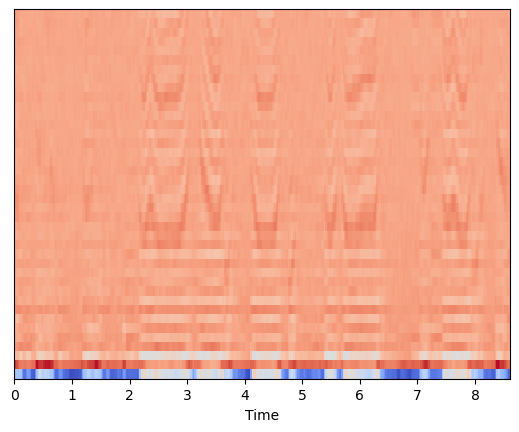

In [19]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
print(mfccs)

In [ ]:
wave2vector

In [ ]:
hubert

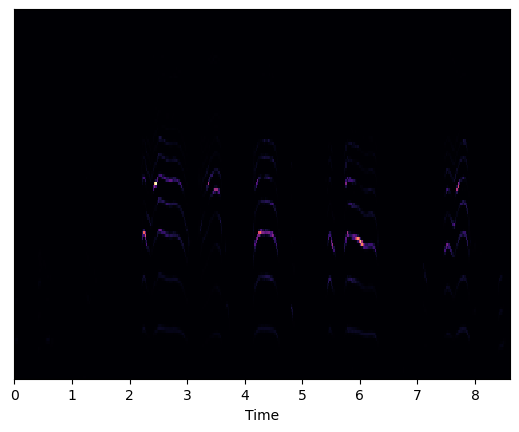

In [20]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=20)
mfccs_delta = librosa.feature.delta(mfccs)
mfccs_delta2 = librosa.feature.delta(mfccs_delta)
# data = np.concatenate((mfccs, mfccs_delta, mfccs_delta2))
# print(mfccs.shape)
# print(mfccs_delta.shape)
# print(mfccs_delta2.shape)
# print(data.shape)
# import librosa.display
# librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

# import librosa.display

# mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
mfccs = librosa.feature.melspectrogram(y=librosa_audio, sr=librosa_sample_rate, 
                                       n_fft=1024, hop_length=512, n_mels=128)
# mfccs = librosa.power_to_db(mfccs) 
# # librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
# shp = mfccs.shape
# mfccs = np.expand_dims(mfccs,axis=2)
# print(mfccs.shape)
# mfccs = tf.image.per_image_standardization(mfccs)
# mfccs = np.reshape(mfccs,shp)
# print(mfccs.shape)
# # print(mfccs)
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

**为每个文件提取MFCCs**

We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe along with it’s classification label.

我们现在将为数据集中的每个音频文件提取一个 MFCC，并将其与分类标签一起存储在 Panda Dataframe 中。

#使用基于CNN的方式  改进识别效果


##提取特征

In [1]:
# max_pad_len = 174
max_pad_len = 500   #控制输入音频的长度

import os
import numpy as np
import librosa
import tensorflow as tf
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs_delta)
        data = np.concatenate((mfccs, mfccs_delta, mfccs_delta2))
        pad_width = max_pad_len - data.shape[1]
        data = np.pad(data, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name, str(e))
        return None 
    return data

In [1]:
# Load various imports 
import pandas as pd
import os
import librosa
import librosa.display
import tensorflow as tf

def build_dataset(basepath):
    wavfilehelper = WavFileHelper()
    features = []
    #获取文件分类列表 ['hug', 'sleepy', 'awake', 'hungry', 'diaper', 'uncomfortable']
    class_name_arr = tf.io.gfile.listdir(basepath)
    for single_filename in class_name_arr:
      #获取文件目录下的文件列表
      # print(basepath+single_filename)
      doc_name_arr = tf.io.gfile.listdir(basepath+single_filename)
      for doc_name_item in doc_name_arr:
        temp_filepath = basepath+single_filename+'/'+doc_name_item
        print(temp_filepath)
        class_label = single_filename
        data = extract_features(temp_filepath)
        features.append([data, class_label])
    return pd.DataFrame(features, columns=['feature','class_label'])
    
# featuresdf = build_dataset('./train/')
# testdf = build_dataset('./temp/')
# 保存变量
# 没有_2的是可以直接用的不用修改 log-mel
# save_variable(featuresdf,'featuresdf_cnn_2.txt')
# save_variable(testdf,'testdf_cnn_2.txt')
# print('Finished feature extraction from ', len(featuresdf), ' files') 

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
#获取变量值
# # Load various imports 
# import pandas as pd
# import numpy as np
# import os
# import librosa
# import librosa.display
# import tensorflow as tf
# featuresdf = load_variavle('featuresdf_cnn_2.txt')
# testdf = load_variavle('testdf_cnn_2.txt')
print

##转换数据和标签  划分训练、测试集
Convert the data and labels

will use `sklearn.preprocessing.LabelEncoder` to encode the categorical text data into model-understandable numerical data

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
x_train = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
x_test = np.array(testdf.feature.tolist())
yt = np.array(testdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y)) 
y_test = to_categorical(le.fit_transform(yt)) 
# split the dataset 


##CNN Arcitechture

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

num_rows = 60
num_columns = 500   
num_channels = 1
# print(x_train.shape)
# x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
# x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
# num_labels = y_train.shape[1]
num_labels = 6
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.summary()

model.add(Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 59, 499, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 249, 16)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 29, 249, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 248, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 124, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 124, 32)       0

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 59, 499, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 249, 16)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 29, 249, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 248, 32)       2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 124, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 14, 124, 32)      

##加载已有模型

In [3]:
#模型加载
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
# model = tf.keras.models.load_model('saved_models/babysound_classification_tf_cnn_improveUrbansound2.h5')

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 59, 499, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 249, 16)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 29, 249, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 248, 32)       2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 124, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 14, 124, 32)      

In [2]:
# model = Model(inputs=model.input, outputs=model.layers[-2].output)   #用来删除层
import keras

prediction = Dense(6, activation='softmax')(model.layers[-2].output)    #用来修改最后一个全连接层

model = Model(inputs=model.input, outputs=prediction)
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
# model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt) 

NameError: name 'Dense' is not defined

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer  [(None, 60, 500, 1)]      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 499, 16)       80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 249, 16)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 29, 249, 16)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 248, 32)       2080      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 124, 32)       0   

##编译、预估

In [4]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [3]:
import os
from pathlib import Path

SAVED_MODEL_PATH = 'C:/Users/Muelsyse/OneDrive/F_Drive/y2z/ReleaseModels/Copy9'
TFLITE_FILE_PATH = 'C:/Users/Muelsyse/OneDrive/F_Drive/y2z/ReleaseModels/Copy9.tflite'

model.load_weights('./saved_models/weights-Copy9.best.basic_cnn.hdf5')
tf.saved_model.save(model, SAVED_MODEL_PATH)

NameError: name 'model' is not defined

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_PATH)
tflite_model = converter.convert()
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

In [27]:
tmp_data = extract_features("./non-label/PBlhdkTYWWU_30.wav")
print(tmp_data.shape)
tmp_data = tmp_data.reshape(1, 60, 500, 1)
print(tmp_data.shape)
output = model.predict(tmp_data)
print(output)
print(np.argmax(output))
print(np.max(output))

(60, 500)
(1, 60, 500, 1)


NameError: name 'model' is not defined

In [28]:
interpreter2 = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter2.allocate_tensors()
input_details = interpreter2.get_input_details()
output_details = interpreter2.get_output_details()
interpreter2.set_tensor(input_details[0]['index'], tmp_data)
interpreter2.invoke()
output_data = interpreter2.get_tensor(output_details[0]['index'])
print(output_data)
interpreter2.set_tensor(input_details[0]['index'], tmp_data)
interpreter2.invoke()
output_data = interpreter2.get_tensor(output_details[0]['index'])
print(output_data)

[[5.6748636e-06 3.6058077e-04 6.5897431e-05 5.6427862e-03 9.9355668e-01
  3.6846942e-04]]
[[5.6748636e-06 3.6058077e-04 6.5897431e-05 5.6427862e-03 9.9355668e-01
  3.6846942e-04]]


## 开训  model.fit()

In [ ]:
from keras.callbacks import ModelCheckpoint 
import tensorflow as tf
from datetime import datetime 

# num_epochs = 12
# num_batch_size = 128
num_epochs = 200
num_batch_size = 32
model.load_weights('saved_models/weights.best.basic_cnn.hdf5')
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',verbose=1, save_best_only=True)
start = datetime.now()
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

##使用模型  预测效果

In [ ]:
def print_prediction(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [ ]:
def print_prediction_sta(file_name):
    prediction_feature = extract_features(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    # predicted_vector = model.predict_classes(prediction_feature)
    predict_x=model.predict(prediction_feature) 
    # print(predict_x)

    classes_x=np.argmax(predict_x,axis=1)

    # print(classes_x)

    # predicted_class = le.inverse_transform(predicted_vector) 
    predicted_class = le.inverse_transform(classes_x) 
    # print(predicted_class)
    # print("The predicted class is:", predicted_class[0], '\n')
    return classes_x[0]
    # print("The predicted class is:", predicted_class[0], '\n') 
    # predicted_proba_vector = model.predict_proba(prediction_feature) 
    # predicted_proba = predicted_proba_vector[0]
    # for i in range(len(predicted_proba)): 
    #     category = le.inverse_transform(np.array([i]))
    #     print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

###开测

In [ ]:
filename = './train/hungry/hungry_5_2_1.wav'
 
print_prediction_sta(filename)

In [ ]:
filename = './test/test_212.wav'
 
print_prediction_sta(filename)

In [ ]:
# Class: predict
class_name_arr = tf.io.gfile.listdir('./test')
# filename = './UrbanSound8K/audio/fold1/24074-1-0-7.wav' 
filename = './test/'+class_name_arr[2]

print_prediction(filename)


#测试集相关函数


In [ ]:
def judgelabel(labelname):
  if labelname=='sleepy':
    return 4
  elif labelname=='hug':
    return 2
  elif labelname=='uncomfortable':
    return 5
  elif labelname=='diaper':
    return 1
  elif labelname=='awake':
    return 0
  elif labelname=='hungry':
    return 3

In [ ]:
import tensorflow as tf

test_file = "./work.zip (Unzipped Files)/work/train"
class_name_arr = tf.io.gfile.listdir(test_file)
print(class_name_arr)
right_item_num = 0
wrong_item_num = 0
for index,single_filename in enumerate(class_name_arr):
    # print(str(index) +"handling...")
    #获取文件目录下的文件列表 并转换文件形式
    doc_name_arr = tf.io.gfile.listdir(test_file+'/'+single_filename)
    temp_label_index = judgelabel(single_filename)
    # print(temp_label_index)
    #处理每个单独的音频元素
    for doc_name_item in doc_name_arr:
      predict_label_index = print_prediction_sta(test_file+'/'+single_filename+'/'+doc_name_item)
      if predict_label_index==temp_label_index:
        right_item_num+=1
      else:
        wrong_item_num+=1
      # print(test_file+'/'+single_filename+'/'+doc_name_item)
print(right_item_num)
print(wrong_item_num)
print(right_item_num/(right_item_num+wrong_item_num))